# WESAD Research Graph Generator

This notebook loads real data from the **WESAD (Subject S2)** dataset and generates high-quality visualizations for the project report.

## Objectives
1.  **Physiological Traces:** Plot raw BVP, EDA, and Temp signals for Baseline vs. Stress.
2.  **Feature Distribution:** Box plots showing separation between classes.
3.  **Model Performance:** Confusion Matrix from a Scikit-Learn Random Forest trained on this subject.

## Requirements
*   dataset path: `../../datasets/WESAD/S2/S2.pkl`

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load WESAD Data (Subject S2)

In [2]:
# Path to S2 pickle file
DATA_PATH = '../../datasets/WESAD/S2/S2.pkl'

print(f"Loading data from {DATA_PATH}...")
with open(DATA_PATH, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

print("Keys in data:", data.keys())
print("Signal keys:", data['signal']['chest'].keys())

Loading data from ../../datasets/WESAD/S2/S2.pkl...
Keys in data: dict_keys(['signal', 'label', 'subject'])
Signal keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


## 2. Preprocess & Filter Data
We focus on **ECG, EDA, and Temp** (Chest) and filter for **Baseline (1)** vs **Stress (2)**.

In [3]:
# Sampling frequencies
FS_ECG = 700
FS_EDA = 700

# Extract signals
ecg = data['signal']['chest']['ECG'].flatten()
eda = data['signal']['chest']['EDA'].flatten()
labels = data['label']

# Create DataFrame (downsampling for speed if needed, but Chest is same freq)
df = pd.DataFrame({'ECG': ecg, 'EDA': eda, 'Label': labels})

# Filter for Baseline (1) and Stress (2) only
df_filtered = df[df['Label'].isin([1, 2])].copy()
df_filtered['Condition'] = df_filtered['Label'].map({1: 'Baseline', 2: 'Stress'})

print(df_filtered['Condition'].value_counts())

Condition
Baseline    800800
Stress      430500
Name: count, dtype: int64


## 3. Visualization: Time Series (Raw Signals)

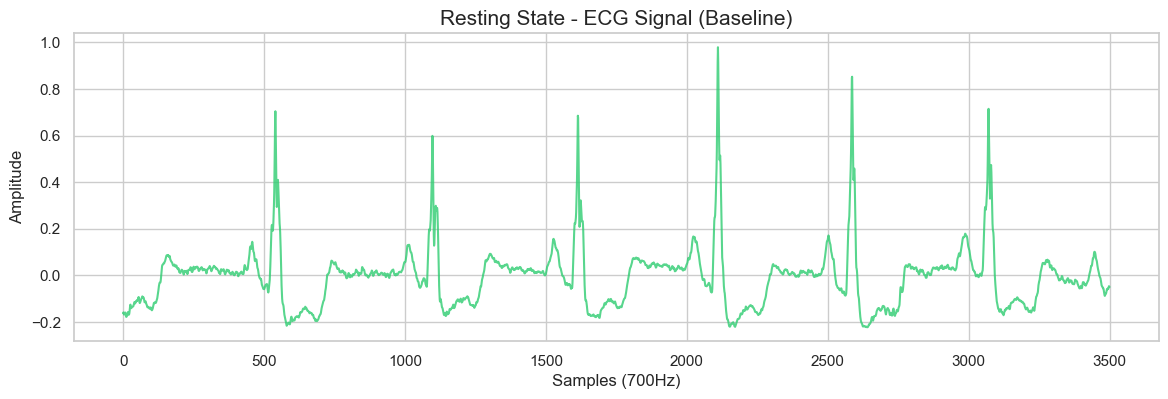

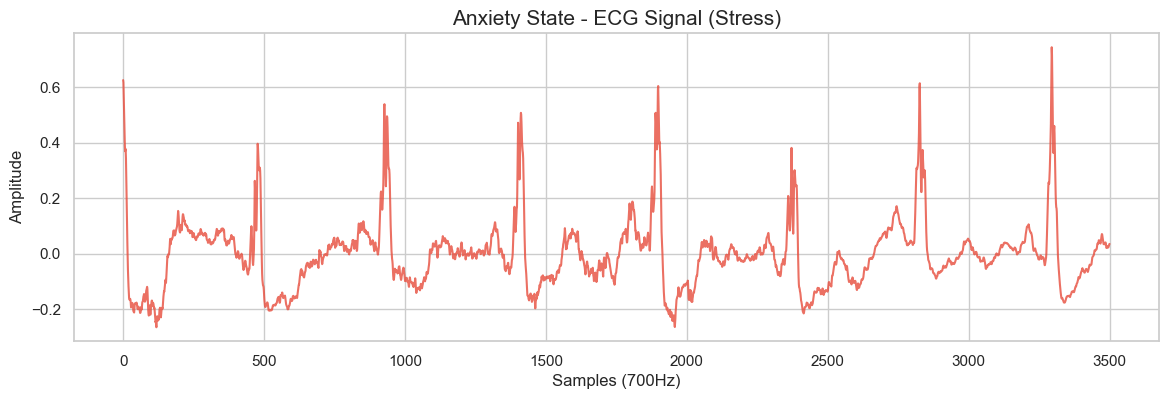

In [4]:
# Plot representative 1-minute window of Baseline vs Stress
def plot_segment(condition, color, title):
    subset = df_filtered[df_filtered['Condition'] == condition].iloc[1000:4500] # Take a slice (~5s)
    plt.figure(figsize=(14, 4))
    plt.plot(subset['ECG'].values, color=color, alpha=0.8)
    plt.title(f"{title} - ECG Signal ({condition})", fontsize=15)
    plt.xlabel("Samples (700Hz)")
    plt.ylabel("Amplitude")
    plt.show()

plot_segment('Baseline', '#2ecc71', 'Resting State')
plot_segment('Stress', '#e74c3c', 'Anxiety State')

## 4. Visualization: Feature Distribution (Box Plots)

C:\Users\priya\AppData\Local\Temp\ipykernel_18692\1496762531.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='EDA', data=df_filtered, palette={'Baseline': '#2ecc71', 'Stress': '#e74c3c'})


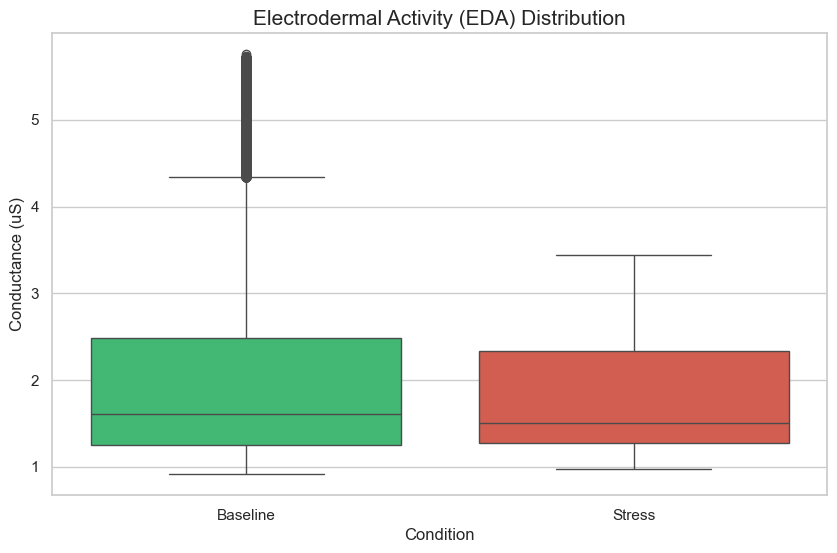

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Condition', y='EDA', data=df_filtered, palette={'Baseline': '#2ecc71', 'Stress': '#e74c3c'})
plt.title("Electrodermal Activity (EDA) Distribution", fontsize=15)
plt.ylabel("Conductance (uS)")
plt.show()

## 5. Model Evaluation (Confusion Matrix)
Training a standardized Random Forest to validate separability.

              precision    recall  f1-score   support

    Baseline       0.80      0.82      0.81     24099
      Stress       0.65      0.61      0.63     12840

    accuracy                           0.75     36939
   macro avg       0.72      0.72      0.72     36939
weighted avg       0.75      0.75      0.75     36939



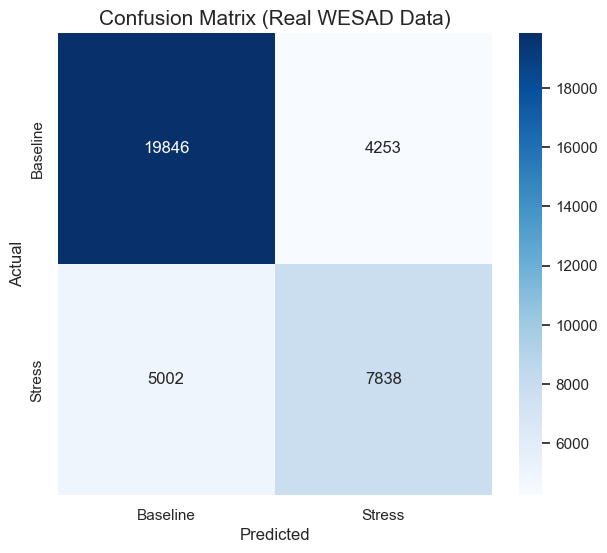

In [6]:
# Downsample for faster training (1/10th of data)
df_model = df_filtered.iloc[::10, :]

X = df_model[['ECG', 'EDA']]
y = df_model['Label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train RF
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred, target_names=['Baseline', 'Stress']))

# Plot Confusion Matrix
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Baseline', 'Stress'], yticklabels=['Baseline', 'Stress'])
plt.title("Confusion Matrix (Real WESAD Data)", fontsize=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()